In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib
import glob
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import time

from skimage import io, exposure, transform

In [52]:
# Dataset: German Traffic Sign Recognition Benchmark (GTSRB) - https://benchmark.ini.rub.de/gtsrb_dataset.html
# download link: https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

# Dataset Path
DATASET_PATH = "/workspace/datasets/archive/train"

In [69]:
# Constants
numclasses = 43
IMAGE_SIZE = [32,32]
RANDOM_SEED = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2
CLASSES = []
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
# # Preprocessing
# import cv2
# import numpy as np
# def preprocess_input(filename):
#     img = io.imread(filename)
#     img = transform.resize(img, IMAGE_INPUT_SIZE)
#     img = exposure.exposure.equalize_adapthist(img, clip_limit=0.1)
#     return img

# # Create TF Image Generator
# datagen = ImageDataGenerator(
#     validation_split=0.2,
#     rescale=1./255,
#     rotation_range=10,
#     zoom_range=0.15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.15,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode="nearest",
# preprocessing_function=preprocess_input)

# # Generate TrainGen & TestGen
# train_generator = datagen.flow_from_directory(
#         DATASET_PATH,
#         subset='training',
#         target_size = IMAGE_INPUT_SIZE,
#         batch_size = 16,
#         shuffle = True,
#         class_mode = 'categorical',
#         seed = RANDOM_SEED)
# validation_generator = datagen.flow_from_directory(
#         DATASET_PATH,
#         subset='validation',
#         target_size = IMAGE_INPUT_SIZE,
#         batch_size = 16,
#         shuffle = True,
#         class_mode = 'categorical',
#         seed = RANDOM_SEED)

In [62]:
def lrfn(epoch):
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8        

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch -
                                                 rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)


def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache()  # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets


def get_label(file_path):
    global CLASSES
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == CLASSES
    # Integer encode the label
    return tf.argmax(one_hot)

# dataset function for folders


def decode_img(img):
    global IMAGE_SIZE
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    # resize the image to the desired size
    print(img)
    return tf.image.resize(img, IMAGE_SIZE)  # [img_height, img_width])


def process_folderpath(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Configure dataset for performance


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def show_oneimage_category(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_batch)
    plt.title(CLASSES[label_batch.numpy()])

In [73]:
def create_model():
    global IMAGE_SIZE
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])


    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            numclasses, activation='softmax', dtype=tf.float32)
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def plot_history(history, metric, val_metric):
    acc = history.history[metric]
    val_acc = history.history[val_metric]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(plt.ylim()), 1])
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()
    fig.savefig('traininghistory.pdf')

In [74]:
def train():
    global CLASSES, IMAGE_SIZE, AUTOTUNE, EPOCHS
    print("Tensorflow Version: ", tf.__version__)
    print("Keras Version: ", tf.keras.__version__)

    strategy = tf.distribute.get_strategy()       
    AUTOTUNE = tf.data.AUTOTUNE


    data_dir = pathlib.Path(DATASET_PATH)
    filelist = (DATASET_PATH+'/*/*')
    datapattern = glob.glob(filelist)
    image_count = len(datapattern)
    list_ds = tf.data.Dataset.list_files(
        str(data_dir/'*/*'), shuffle=False)
    list_ds = list_ds.shuffle(
        image_count, reshuffle_each_iteration=False)
    CLASSES = np.array(sorted(
        [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
    # Split the dataset into train and validation:
    val_size = int(image_count * VALIDATION_SPLIT)
    train_ds = list_ds.skip(val_size)
    val_ds = list_ds.take(val_size)

    # see the length of each dataset as follows:
    train_len = tf.data.experimental.cardinality(train_ds).numpy()
    print('Training data len:', train_len)
    val_len = tf.data.experimental.cardinality(val_ds).numpy()
    print('Validation data len:', val_len)

    # Use Dataset.map to create a dataset of image, label pairs:
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    train_ds = train_ds.map(
        process_folderpath, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(process_folderpath,
                        num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds)
    val_ds = configure_for_performance(val_ds)

    image_batch, label_batch = next(iter(train_ds))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(CLASSES[label])
        plt.axis("off")
    else:
        print('Data type not correct')


    lr_callback = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lrfn(epoch), verbose=True)

    rng = [i for i in range(EPOCHS)]
    y = [lrfn(x) for x in rng]
    plt.plot(rng, [lrfn(x) for x in rng])
    print(y[0], y[-1])

#     with strategy.scope():  # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
    model.summary()

    start_time = time.time()
    EPOCHS = 30
#         TRAIN_STEPS = 2936 // BATCH_SIZE  # 2936 is the length of train data
#         history = model.fit(train_ds, validation_data=val_ds,
#                             steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
    final_accuracy = history.history["val_accuracy"][-5:]
    print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
    print("TRAINING TIME: ", time.time() - start_time, " sec")

    plot_history(history, 'accuracy', 'val_accuracy')

Tensorflow Version:  2.6.0
Keras Version:  2.6.0
Training data len: 31368
Validation data len: 7841
Tensor("decode_image/DecodeImage:0", shape=(None, None, 3), dtype=uint8)
Tensor("decode_image/DecodeImage:0", shape=(None, None, 3), dtype=uint8)
Data type not correct
1e-05 1.0897249631745235e-05
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                22059     
Total params: 14,736,747
Trainable params: 14,736,747
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1961/1961 [==============================] - 75s 36ms/step - los

KeyboardInterrupt: 

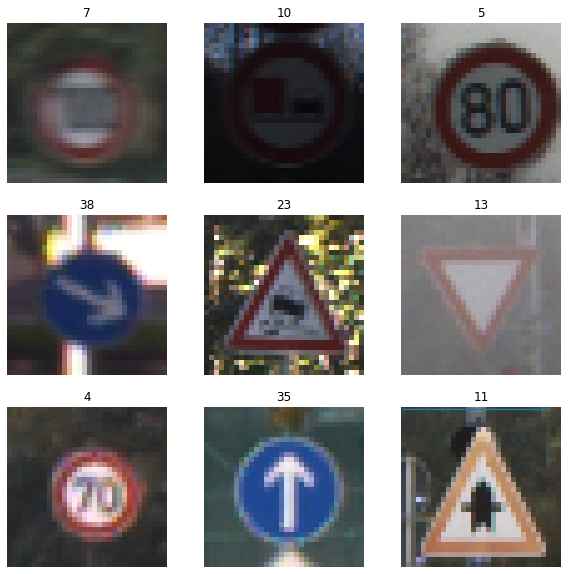

In [75]:
train()